In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D , Conv2DTranspose , Flatten , Dropout , Dense , LeakyReLU , Reshape, BatchNormalization
from tensorflow.keras.models import Sequential
import random

from tensorflow.keras.datasets import mnist

In [193]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [194]:
(x_train, y_train) , (_, _) = mnist.load_data()

In [195]:
x_train[0].shape

(28, 28)

### Visualize some images

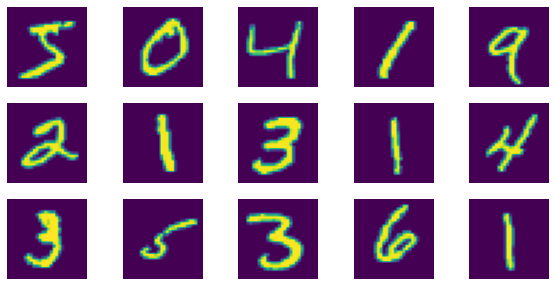

In [196]:
 plt.figure(figsize=(10 , 5))

for i in range(15):
    plt.subplot(3 , 5 , i+1)
    plt.imshow(x_train[i])
    plt.axis('off')

In [197]:
only_nines= x_train[y_train==9]

print(len(only_nines))

5949


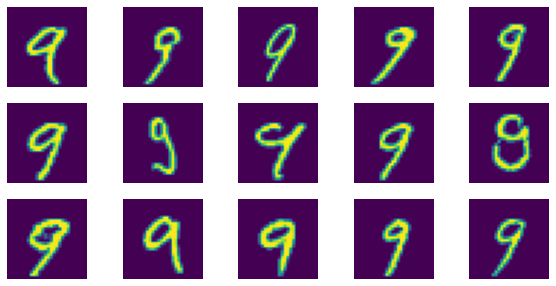

In [198]:
 plt.figure(figsize=(10 , 5))

for i in range(15):
    plt.subplot(3 , 5 , i+1)
    plt.imshow(only_nines[i])
    plt.axis('off')

In [199]:
def build_discriminator(in_shape=(28,28,1)):

    model = Sequential()

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))


    model.add(Flatten()) 
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) #shape of 1

    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), 
                  metrics=['accuracy'])
  

    return model

In [200]:
test_discr = build_discriminator()
print(test_discr.summary())

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_76 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_77 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 flatten_15 (Flatten)        (None, 6272)              0         
                                                                 
 dropout_15 (Dropout)        (None, 6272)              0         
                                                                 
 dense_30 (Dense)            (None, 1)               

In [201]:
def build_generator(latent_dim):    
    model = Sequential()

    n_nodes = 7 * 7 * 128  #8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim)) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))  #8x8x128 

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(1, (8,8), activation='tanh', padding='same')) 
    return model

In [202]:
test_gen = build_generator(100)
print(test_gen.summary())


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 6272)              633472    
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_15 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 14, 14, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_79 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 28, 28, 128)      262272    
 Transpose)                                          

In [203]:
def build_GAN(generator, discriminator):
    discriminator.trainable = False  
    # connect generator and discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))
  

    return model


In [204]:
def load_images():
    (x_train, y_train), (_, _) =  mnist.load_data()
    only_nines= x_train[y_train==9]
    # cConvert to float and scale.
    X = only_nines.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                                #original images to -1 to 1 to match the output of generator.
    return X

In [205]:
def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    X = dataset[ix]
    # generate class labels and assign to y
    y = np.ones((n_samples, 1)) ##Label=1 indicating they are real
    return X, y

In [206]:
# generate n_samples number of latent vectors as input for the generator

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [207]:
# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict using generator to generate fake samples. 
    X = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake. 
    y = np.zeros((n_samples, 1))  #Label=0 indicating they are fake
    return X, y


In [208]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
  
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2) 
    for i in range(n_epochs):
            
        for j in range(batch_per_epoch):

                    
            X_real, y_real = generate_real_samples(dataset, half_batch)

            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 

            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)


            X_gan = generate_latent_points(latent_dim, n_batch)


            y_gan = np.ones((n_batch, 1))


            g_loss = gan_model.train_on_batch(X_gan, y_gan)


            print(f'Epoch> {i+1}, Batch {j+1}, bat/ep={batch_per_epoch}, real_loss={d_loss_real:.2f}, gan_loss={g_loss:.2f}')
                # save the generator model
    g_model.save('mnist_only_nines.h5')

### Commented to decrease the size of notebook after training

In [209]:
# # size of the latent space
latent_dim = 100
# # create the discriminator
discriminator = build_discriminator()
# # create the generator
generator = build_generator(latent_dim)
# # create the GAN
gan_model = build_GAN(generator, discriminator)
# # load image data
dataset = load_images()
# # train model
gan_history= train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=300)

1/1 [==============================] - 0s 96ms/step
Epoch> 1, Batch 1, bat/ep=92, real_loss=0.63, gan_loss=0.69
1/1 [==============================] - 0s 15ms/step
Epoch> 1, Batch 2, bat/ep=92, real_loss=0.51, gan_loss=0.67
1/1 [==============================] - 0s 15ms/step
Epoch> 1, Batch 3, bat/ep=92, real_loss=0.41, gan_loss=0.65
1/1 [==============================] - 0s 17ms/step
Epoch> 1, Batch 4, bat/ep=92, real_loss=0.34, gan_loss=0.63
1/1 [==============================] - 0s 16ms/step
Epoch> 1, Batch 5, bat/ep=92, real_loss=0.28, gan_loss=0.59
1/1 [==============================] - 0s 16ms/step
Epoch> 1, Batch 6, bat/ep=92, real_loss=0.22, gan_loss=0.55
1/1 [==============================] - 0s 15ms/step
Epoch> 1, Batch 7, bat/ep=92, real_loss=0.19, gan_loss=0.50
1/1 [==============================] - 0s 16ms/step
Epoch> 1, Batch 8, bat/ep=92, real_loss=0.16, gan_loss=0.46
1/1 [==============================] - 0s 15ms/step
Epoch> 1, Batch 9, bat/ep=92, real_loss=0.15, gan_lo

### Visualizing totally unrealistic nines-generated images

In [221]:
def show_plot(examples, n):
    
    plt.figure(figsize=(8 , 8))

    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()

1/1 [==============================] - 0s 108ms/step


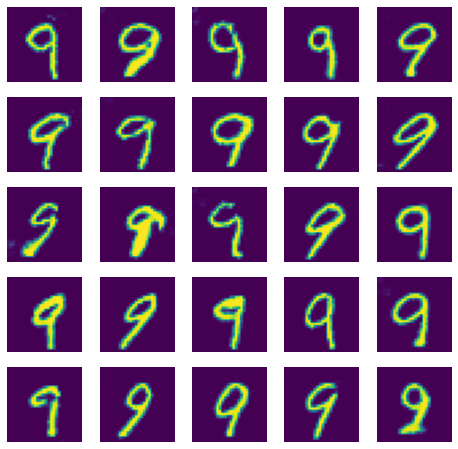

In [222]:
# load model
model = tf.keras.models.load_model('mnist_only_nines.h5') 
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

X = (X*255).astype('float32')

# plot the result

show_plot(X, 5)